In [1]:
%matplotlib inline
import warnings; warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import torch
from torch.autograd import Variable

In [2]:
from read_results import read_varnames
varnames = read_varnames("smog_code/smog_Parameters.f90")[0:12]
print(len(varnames), varnames)

12 ['HNO3', 'O', 'RH', 'RCOO2NO2', 'O3', 'HO2', 'RCOO2', 'RCHO', 'RO2', 'NO', 'NO2', 'OH']


# KPP default initial value

In [3]:
df_init = pd.Series(data=1e-8, index=varnames)
df_init['RH'] = 2.0
df_init['RCHO'] = 2.0
df_init['NO'] = 0.5
df_init['NO2'] = 0.1
df_init

HNO3        1.000000e-08
O           1.000000e-08
RH          2.000000e+00
RCOO2NO2    1.000000e-08
O3          1.000000e-08
HO2         1.000000e-08
RCOO2       1.000000e-08
RCHO        2.000000e+00
RO2         1.000000e-08
NO          5.000000e-01
NO2         1.000000e-01
OH          1.000000e-08
dtype: float64

# Integrate forward

In [4]:
import smog_code.kpp4py as kpp

In [5]:
y_history = kpp.forward(df_init.values, 30)
y_history.shape

(12, 30)

In [6]:
df_history = pd.DataFrame(y_history.T, columns=varnames)
df_history.index.name = 'time'
df_history.head()

,HNO3,O,RH,RCOO2NO2,O3,HO2,RCOO2,RCHO,RO2,NO,NO2,OH
time,,,,,,,,,,,,
0,0.011969,0.047323,1.977752,0.033784,0.046263,9.376380e-07,4.809425e-07,1.988463,8.080372e-07,0.166118,0.388129,3.142789e-08
1,0.022814,0.054516,1.966015,0.068263,0.142359,1.834471e-06,6.655699e-07,1.965720,1.441752e-06,0.062340,0.446584,2.289512e-08
2,0.032028,0.052796,1.956457,0.103805,0.270224,3.193612e-06,9.467450e-07,1.939735,2.406003e-06,0.031787,0.432380,2.061908e-08
3,0.040186,0.048891,1.947524,0.139794,0.402131,4.864673e-06,1.303912e-06,1.912677,3.600820e-06,0.019676,0.400344,1.992698e-08
4,0.047505,0.044335,1.938809,0.175995,0.533059,6.894217e-06,1.748860e-06,1.885189,5.061861e-06,0.013483,0.363017,1.973133e-08


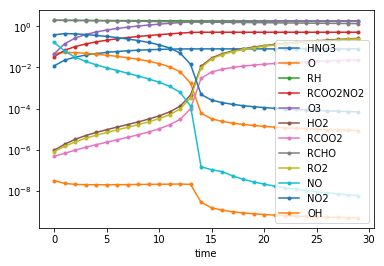

In [7]:
df_history.plot(y=None, logy=True, marker='.')

# Get data range

In [8]:
df_range = df_history.agg(['min', 'max']).T
df_range

,min,max
HNO3,1.196871e-02,8.030713e-02
O,8.425274e-06,5.451626e-02
RH,1.850661e+00,1.977752e+00
RCOO2NO2,3.378443e-02,5.196239e-01
O3,4.626326e-02,1.750093e+00
HO2,9.376380e-07,2.617925e-01
RCOO2,4.809425e-07,2.341105e-02
RCHO,1.358315e+00,1.988463e+00
RO2,8.080372e-07,2.479889e-01
NO,5.853498e-09,1.661183e-01


# Generate random samples within that range

In [9]:
y0_list = np.random.uniform(df_range['min'], df_range['max'], size=(5000, 12) )
y0_list.shape

(5000, 12)

In [10]:
%%time
y1_list = kpp.onestep(y0_list.T).T

CPU times: user 453 ms, sys: 6.78 ms, total: 460 ms
Wall time: 464 ms


In [11]:
y1_list.min(axis=0) # make sure no negative value

array([  1.32033557e-02,   4.79334808e-06,   1.75503341e+00,
         5.68228265e-02,   1.13824908e-01,   4.72478692e-06,
         1.15760848e-06,   1.17224560e+00,   3.77920575e-06,
         4.22257289e-09,   3.92576187e-05,   2.94607216e-10])

# Normalize data

In [12]:
normalizer = StandardScaler()
normalizer.fit(y0_list)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
X_train = normalizer.transform(y0_list)
X_train.shape

(5000, 12)

In [14]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([ 1.19834551,  0.76135081,  1.09478295,  1.17690515,  1.03379024,
        0.78047764,  0.37452765,  1.00387002,  0.56422253,  0.04613124,
        0.76287695,  1.19639571])

# Fit ANN

In [15]:
x_torch = Variable(torch.from_numpy(X_train).type(torch.FloatTensor))
y_torch = Variable(torch.from_numpy(Y_train).type(torch.FloatTensor))

In [16]:
H1, H2 = 30, 30

model = torch.nn.Sequential(
    torch.nn.Linear(12, H1),
    torch.nn.ReLU(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 12)
)

In [17]:
loss_fn = torch.nn.MSELoss()

#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

for t in range(3000):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%200==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

200 0.0475788377225399
400 0.006369672250002623
600 0.003833506256341934
800 0.0020413282327353954
1000 0.0016430473187938333
1200 0.0014653828693553805
1400 0.0013489872217178345
1600 0.0014032989274710417
1800 0.0010131488088518381
2000 0.000893044110853225
2200 0.0008409390575252473
2400 0.0011322845239192247
2600 0.0007791779935359955
2800 0.0007583689293824136
3000 0.0007400992326438427


In [18]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 2.61 ms, sys: 755 µs, total: 3.37 ms
Wall time: 2.34 ms


In [19]:
y_pred_numpy.shape

(5000, 12)

In [20]:
r2_score(y_pred_numpy, Y_train)

0.98531424144405355

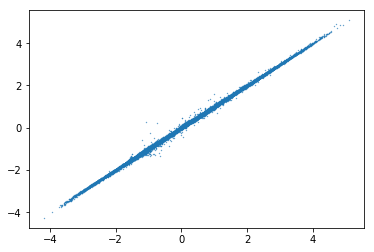

In [21]:
plt.scatter(y_pred_numpy.ravel(), Y_train.ravel(), s=0.1)

# Make new prediction

In [22]:
y0_test = np.random.uniform(df_range['min'], df_range['max'], size=(5000, 12) )

In [23]:
y1_test = kpp.onestep(y0_test.T).T

In [24]:
X_test = normalizer.transform(y0_test)
Y_test = normalizer.transform(y1_test)

In [25]:
Y_test.shape

(5000, 12)

In [26]:
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor))
y_test_pred = model(X_torch_test).data.numpy()
y_test_pred.shape

(5000, 12)

In [27]:
r2_score(y_test_pred, Y_test)

0.98619690271526705

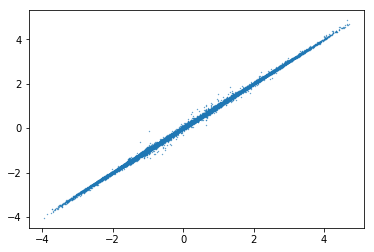

In [28]:
plt.scatter(y_test_pred, Y_test, s=0.1)

# Integrate forward in time

## Reference result

In [43]:
y_start = y0_test[3]
y_history_true = kpp.forward(y_start, 10).T

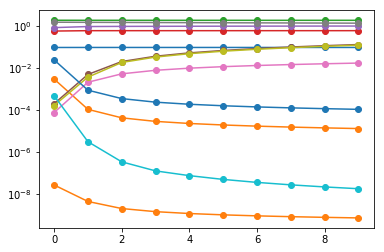

In [44]:
plt.plot(y_history_true, '-o')
plt.yscale('log')

## In normalized space

In [45]:
y_history_true_normed = normalizer.transform(y_history_true)

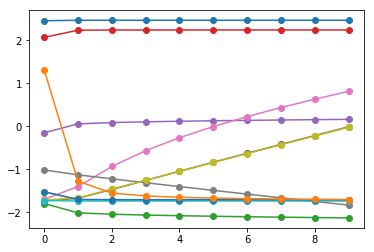

In [46]:
plt.plot(y_history_true_normed, '-o');

## ANN prediction

In [47]:
y_start_normed = normalizer.transform(y_start.reshape(1,-1))

In [48]:
y_history_pred = []

v_torch_temp = Variable(torch.from_numpy(y_start_normed).type(torch.FloatTensor))

for t in range(10):
    v_torch_temp = model(v_torch_temp)
    y_history_pred.append(v_torch_temp.data.numpy().ravel())
    
y_history_pred = np.array(y_history_pred)

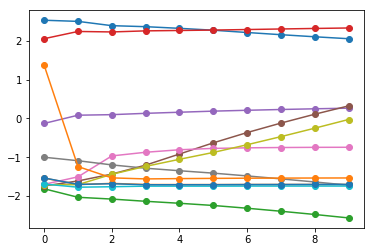

In [49]:
plt.plot(y_history_pred, '-o');

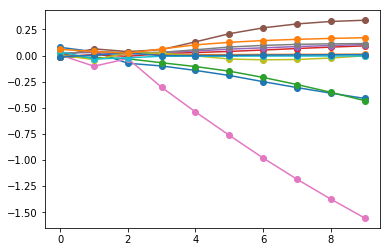

In [50]:
plt.plot(y_history_pred - y_history_true_normed, '-o');